In [32]:
import json
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
import toolkit.allen_helpers.stimuli as st
import toolkit.pipeline.signal as ps
from toolkit.pipeline.data_io import SessionDirectory
from toolkit.analysis.signal import bandpass_power
from toolkit.plots.plots import plot_channel_signal_array
from toolkit.paths import RESULTS_DIR
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS

pd.set_option('display.max_columns', None)

with open('config.json') as f:
    config = json.load(f)

## Get session and load data

In [2]:
session_id = config['session_id']
ecephys_structure_acronym = config['ecephys_structure_acronym']
print(f"Session ID: {session_id}")

Session ID: 721123822


In [3]:
session_dir = SessionDirectory(session_id, ecephys_structure_acronym, cache_lfp=True)

probe_info = session_dir.load_probe_info()
if not session_dir.has_lfp_data:
    raise ValueError(f"Session {session_id} has no LFP data")

session = session_dir.session

c:\Users\ziaochen\.conda\envs\allen\lib\site-packages\hdmf\spec\namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [4]:
stimulus_presentations = session.stimulus_presentations
session_type = session.session_type
drifting_gratings_stimuli = st.STIMULUS_CATEGORIES[session_type]['drifting_gratings']

In [33]:
central_channels = probe_info['central_channels']

lfp_channels = session_dir.load_lfp_channels()
channel_positions = lfp_channels['probe_vertical_position']

csd_array = session_dir.load_csd()

bands_ds = session_dir.load_wave_bands()
preferred_orientation = session_dir.load_preferred_orientations().sel(
    layer=GLOBAL_SETTINGS['layer_of_interest']).item()

# load bands of interest
bands_of_interest = xr.load_dataarray(RESULTS_DIR / f'bands_of_interest.nc')

## Analyze data

In [6]:
extend_time = 1.0  # extend time at the start and end of each block to avoid boundary effect for filtering

wave_bands = bands_ds.wave_band.values

csd_plot_kwargs = dict(
    central_channels=central_channels,
    ccf_coordinates=lfp_channels['dorsal_ventral_ccf_coordinate']
)

### Flashes CSD

In [19]:
stim = 'flashes'
flashes_window = (-0.2, 0.75)  # right boundary < extend_time

In [20]:
flashes_trials = st.get_stimulus_trials(stimulus_presentations, stim)
flashes_blocks = st.get_stimulus_blocks(flashes_trials)

In [21]:
window = (flashes_window[0], flashes_trials.duration + flashes_window[1])
aligned_csd = st.align_trials_from_blocks(csd_array, flashes_blocks, window=window, ignore_nan_trials='any')[0]
average_csd = aligned_csd.mean(dim='presentation_id', keep_attrs=True)
total_power = (aligned_csd ** 2).mean(dim=('presentation_id', 'time_from_presentation_onset'))

In [22]:
freq_bands = {}
for wave_band in wave_bands:
    freq_band = ps.get_band_with_highest_peak(bands_ds.sel(stimulus=stim, wave_band=wave_band))
    if freq_band is not None:
        freq_bands[wave_band] = freq_band.values

aligned_csd_power = {}
for wave_band, freq_band in freq_bands.items():
    csd_power = bandpass_power(ps.bandpass_filter_blocks(
        csd_array, flashes_blocks, freq_band,
        extend_time=extend_time,
        include_filtered=False,
        include_amplitude=True
    ))

    aligned_csd_power[wave_band] = st.align_trials_from_blocks(
        csd_power, flashes_blocks, window=window
    )[0].mean(dim='presentation_id', keep_attrs=True)

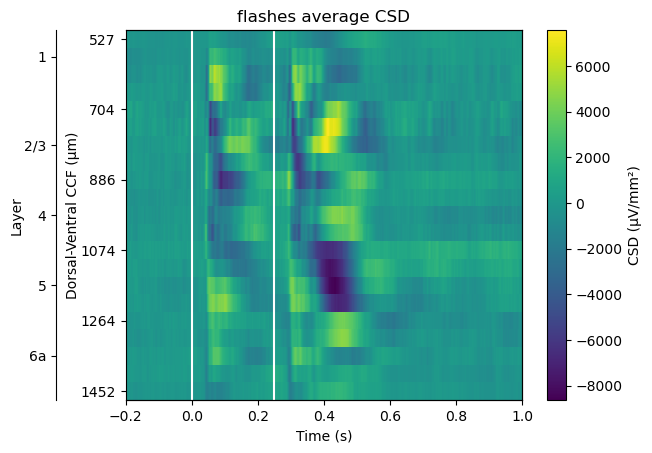

In [23]:
ax = plot_channel_signal_array(
    average_csd.time_from_presentation_onset, channel_positions,
    average_csd, clabel='CSD', **csd_plot_kwargs
)
ax.axvline(0, color='w')
ax.axvline(flashes_trials.duration, color='w')
ax.set_title(f'{stim} average CSD')

plt.show()

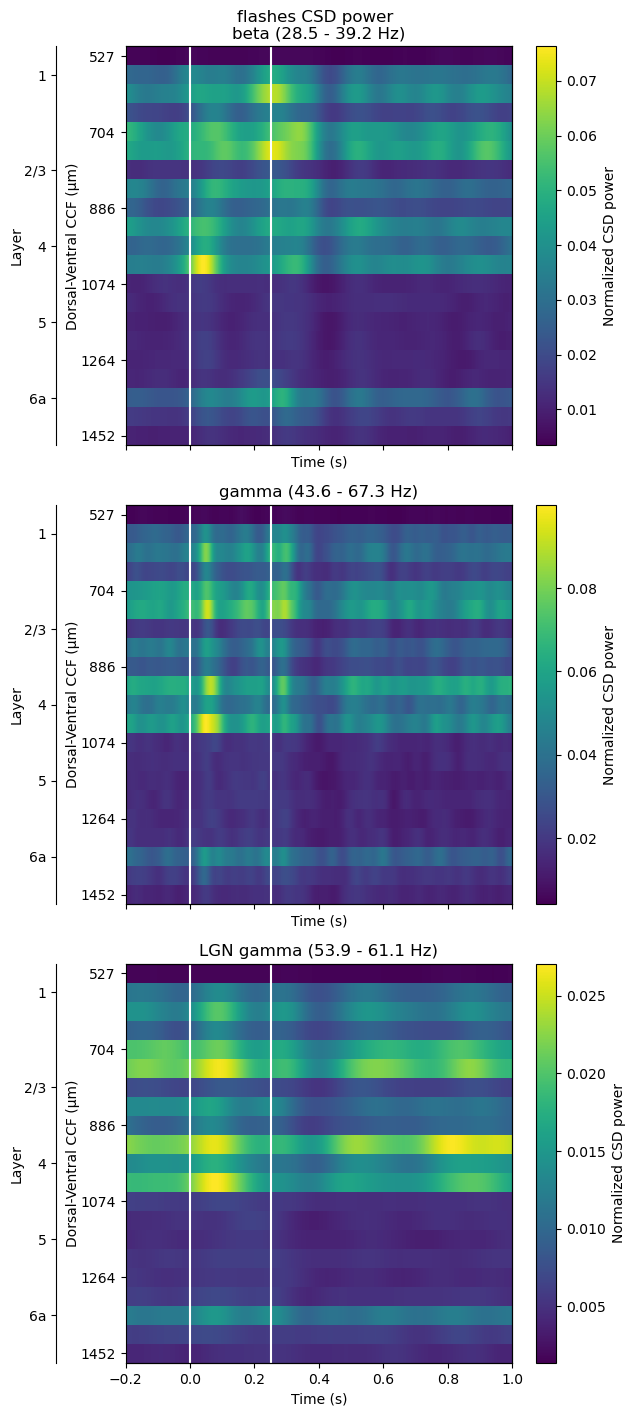

In [24]:
fig, axs = plt.subplots(len(freq_bands), 1, figsize=(6.4, 4.8 * len(freq_bands)),
    sharex=True, squeeze=False)
for ax, (wave_band, csd_power) in zip(axs.ravel(), aligned_csd_power.items()):
    plot_channel_signal_array(
        csd_power.time_from_presentation_onset, channel_positions,
        csd_power / total_power, clabel='Normalized CSD power', **csd_plot_kwargs, ax=ax
    )
    ax.axvline(0, color='w')
    ax.axvline(flashes_trials.duration, color='w')
    band = freq_bands[wave_band]
    ax.set_title(f'{wave_band} ({band[0]:.1f} - {band[1]:.1f} Hz)')
fig.suptitle(f'{stim} CSD power')
fig.tight_layout()
plt.show()

### Drifting gratings CSD

In [25]:
stim = drifting_gratings_stimuli[0]  # first drifting grating stimulus
drifting_gratings_window = (-0.5, 0.5)  # right boundary < extend_time

In [ ]:
drifting_gratings_trials = st.get_stimulus_trials(stimulus_presentations, stim)
drifting_gratings_blocks = st.get_stimulus_blocks(drifting_gratings_trials)
conditions = st.presentation_conditions(drifting_gratings_trials.presentations)

In [ ]:
window = (drifting_gratings_window[0], drifting_gratings_trials.duration + drifting_gratings_window[1])
aligned_csd, valid_trials = st.align_trials(csd_array, drifting_gratings_trials, window=window, ignore_nan_trials='any')
if valid_trials is not None:  # if any trial is dropped by NaN values
    cond_presentation_id = st.presentation_conditions(valid_trials.presentations)[1]
    if len(conditions[1]) != len(cond_presentation_id):
        diff = set(conditions[1].keys()) - set(cond_presentation_id.keys())
        raise ValueError(f"All trials are dropped by NaN values in {stim} for conditions: {diff}")
    conditions = (conditions[0], cond_presentation_id)


In [37]:
conditions[0].sel(orientation=preferred_orientation)

<xarray.DataArray 'condition_id' (temporal_frequency: 5, contrast: 1)>
array([[268],
       [284],
       [278],
       [252],
       [279]])
Coordinates:
    orientation         float64 45.0
  * temporal_frequency  (temporal_frequency) float64 1.0 2.0 4.0 8.0 15.0
  * contrast            (contrast) float64 0.8

In [ ]:
average_csd = aligned_csd.mean(dim='presentation_id', keep_attrs=True)
total_power = (aligned_csd ** 2).mean(dim=('presentation_id', 'time_from_presentation_onset'))

In [16]:
freq_bands = {}
for wave_band in wave_bands:
    # check if wave band is already extracted from layer of interest
    if wave_band in bands_of_interest.wave_band and session_id in bands_of_interest.session_id:
        freq_band = bands_of_interest.sel(wave_band=wave_band, session_id=session_id)
    else:  # fallback to extract from all layers
        freq_band = ps.get_band_with_highest_peak(bands_ds.sel(stimulus=stim, wave_band=wave_band))
    if freq_band is not None:
        freq_bands[wave_band] = freq_band.values

aligned_csd_power = {}
for wave_band, freq_band in freq_bands.items():
    csd_power = bandpass_power(ps.bandpass_filter_blocks(
        csd_array, drifting_gratings_blocks, freq_band,
        extend_time=extend_time,
        include_filtered=False,
        include_amplitude=True
    ))

    aligned_csd_power[wave_band] = st.align_trials_from_blocks(
        csd_power, drifting_gratings_blocks, window=window
    )[0].mean(dim='presentation_id', keep_attrs=True)

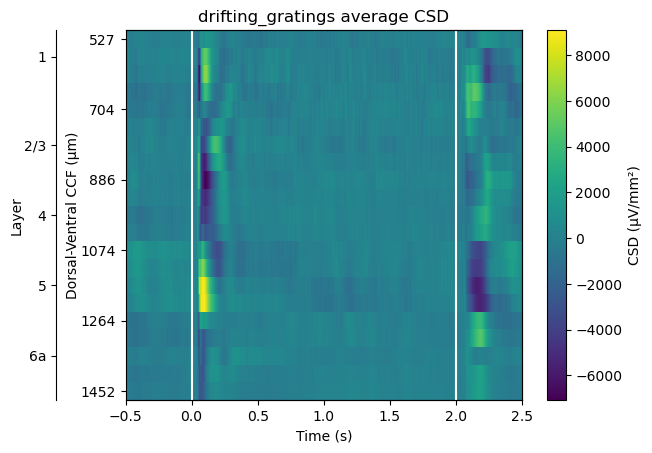

In [17]:
ax = plot_channel_signal_array(
    average_csd.time_from_presentation_onset, channel_positions,
    average_csd, clabel='CSD', **csd_plot_kwargs
)

ax.axvline(0, color='w')
ax.axvline(drifting_gratings_trials.duration, color='w')
ax.set_title(f'{stim} average CSD')

plt.show()

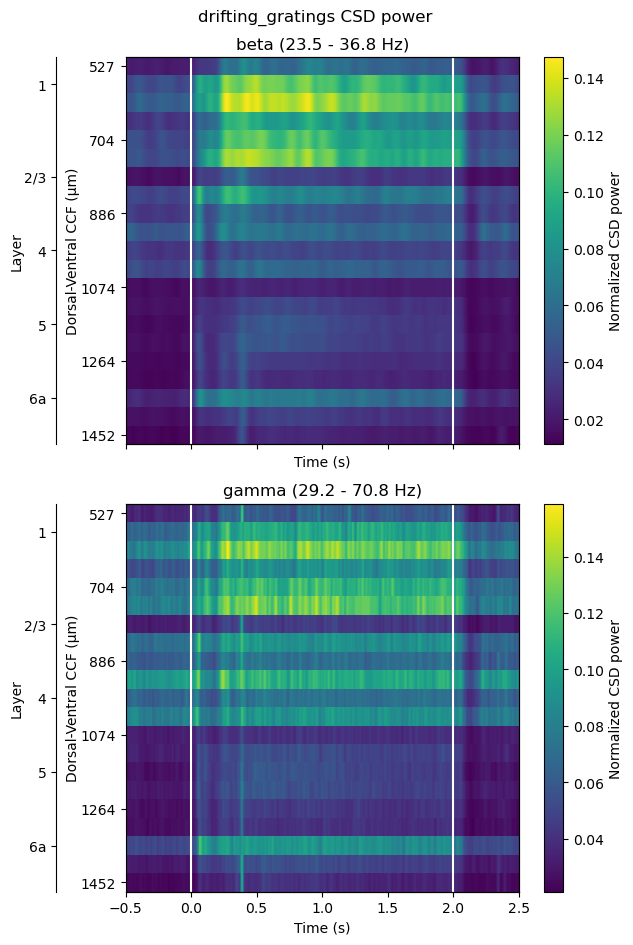

In [18]:
fig, axs = plt.subplots(len(freq_bands), 1, figsize=(6.4, 4.8 * len(freq_bands)),
    sharex=True, squeeze=False)
for ax, (wave_band, csd_power) in zip(axs.ravel(), aligned_csd_power.items()):
    plot_channel_signal_array(
        csd_power.time_from_presentation_onset, channel_positions,
        csd_power / total_power, clabel='Normalized CSD power', **csd_plot_kwargs, ax=ax
    )
    ax.axvline(0, color='w')
    ax.axvline(drifting_gratings_trials.duration, color='w')
    band = freq_bands[wave_band]
    ax.set_title(f'{wave_band} ({band[0]:.1f} - {band[1]:.1f} Hz)')
fig.suptitle(f'{stim} CSD power')
fig.tight_layout()
plt.show()